# 🙋‍♂️ Preamble 🙋‍♂️ #

Name : Ayoub Choukri

Date : 18 November 2023

Subject : Predicting Pizza Brand based on its ingredients

**🤞Note🤞** : This notebook is a part of a series of notebooks that I will be publishing on my [Github]() and [Kaggle]() accounts. Please feel free to check them out and give me your feedback.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
from mca import *

# 🍕General Context🍕

Pizza is one of my favorite meals. Who else likes pizza? 🙋‍♂️ You don't ? Well, there are so many things to like in a pizza. Let's have a closer look.


The DataSet that I am going to use is a Kaggle DataSet that contains measurments that capture the quantity of things that make a pizza tasty. The goal of this notebook is to predict the brand of a pizza based on its ingredients.

The DataSet can be found on : [DataSet Source](https://www.kaggle.com/datasets/shishir349/can-pizza-be-healthy/data)

<img src="./Images/Pizza.jpg" alt="Pizza" />

![]("./Images/pizza.jpg")

# 🍕Importing The Data Set 🍕

In [6]:
data = pd.read_csv("./Data/Pizza.csv")
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

# 🧹Data Preprocessing🧹

Let's take a look to ou DataSet

In [7]:
data.sample(5)

,brand,id,mois,prot,fat,ash,sodium,carb,cal
255,I,14114,54.51,9.93,12.66,2.07,0.53,20.83,2.37
225,H,24024,35.80,7.82,14.08,1.43,0.42,40.87,3.21
121,E,14099,35.14,8.05,15.77,1.38,0.41,39.66,3.33
164,F,24046,29.59,8.05,14.07,1.44,0.45,46.22,3.49
119,E,14089,34.58,7.44,16.24,1.31,0.39,40.43,3.38


In [8]:
data.shape

(300, 9)

Let's put each variable in its right dtype

In [9]:
df=data.copy()
categorical_columns = ['brand','id']
numerical_columns=['mois','prot','fat','ash','sodium','carb','cal']


In [10]:
df[categorical_columns] = df[categorical_columns].astype('category')
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

## Missing Values

<Axes: >

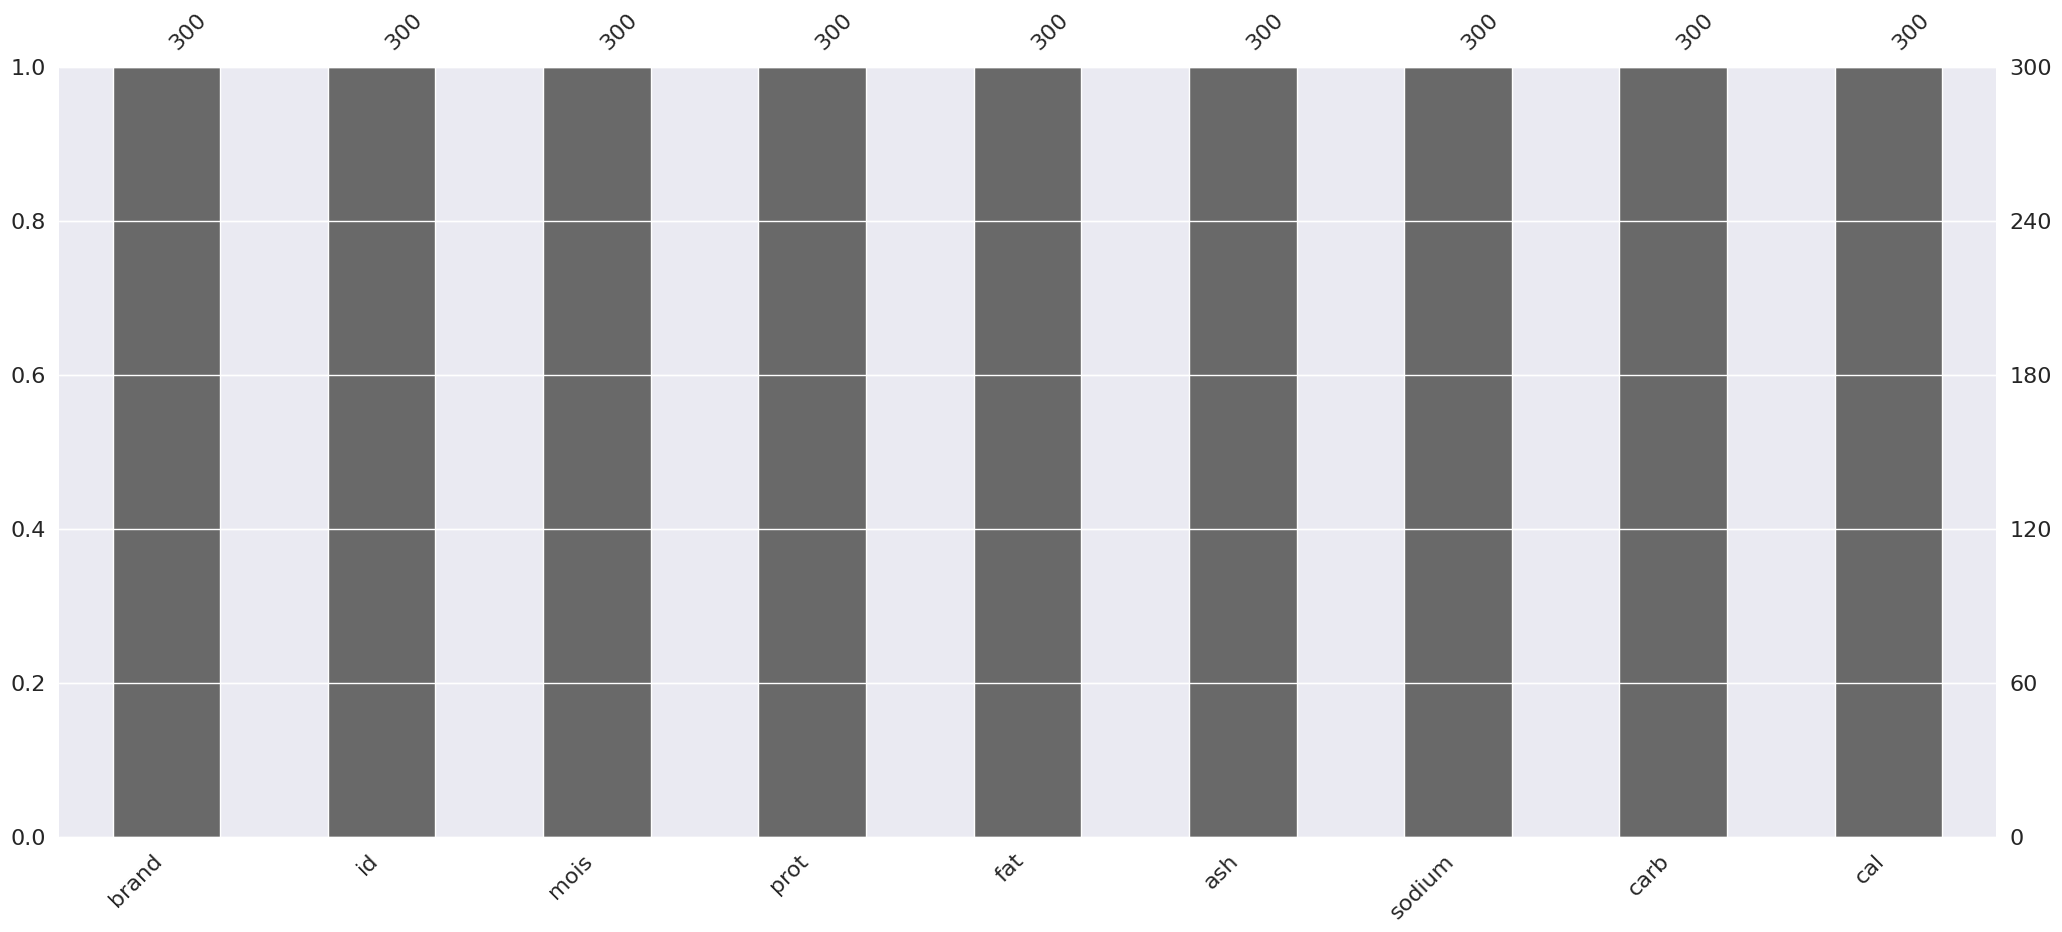

In [11]:
msn.bar(df)

We notice that there are no missing values in the dataset.

# 📊📈 Descriptive Analysis📊📈

### Boxplots and Outliers

Text(0.5, 1.0, 'Box plot of numerical columns')

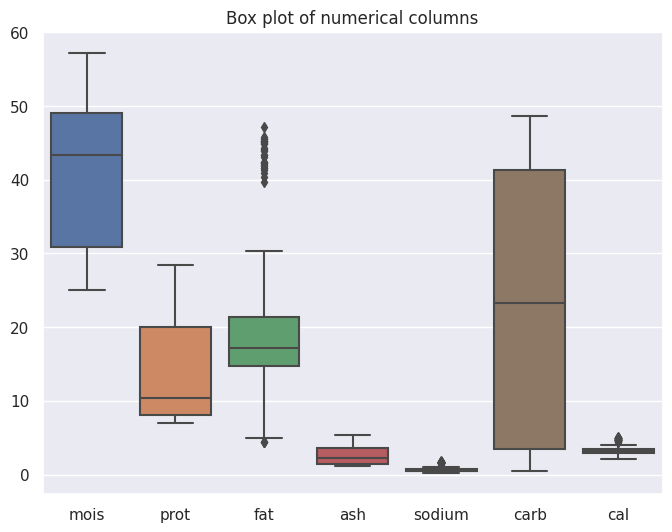

In [12]:
plt.figure(figsize=(8,6))
i=sns.boxplot(data[numerical_columns])
plt.title("Box plot of numerical columns")

Considering the fact that our numerical does not have the same unit. We will scale the Data.

In [13]:
df[numerical_columns]=(df[numerical_columns]-df[numerical_columns].mean())/df[numerical_columns].std()

Text(0.5, 1.0, 'Box plot of numerical columns')

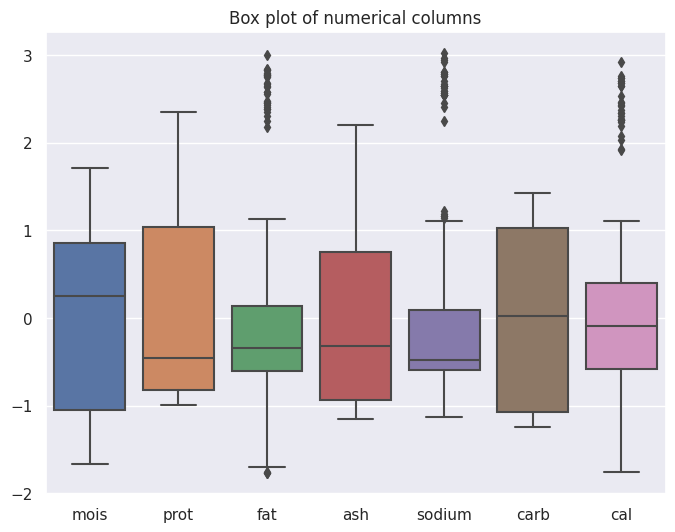

In [14]:
plt.figure(figsize=(8,6))
i=sns.boxplot(df[numerical_columns])
plt.title("Box plot of numerical columns")

We notice that the boxplots have pretty much the same shape. However, we notice the presence of some Outliers in the data. I decided to first keep them and see how the model will perform. If the model does not perform well, I will remove them.

## 🔢📏 Quantitative Variables🔢📏

### Densities

I will estimate the density of the numerical columns using the kernel density estimation method.

In [15]:
def density(data,plot_variables,size,color,l,c,nmax=None):
    fig, axes = plt.subplots(l,c,figsize=size)
    for i in range(l):
        for j in range(0,c):
            sns.kdeplot(data[plot_variables[c*i+j]],ax=axes[i,j],color=color,fill=True)
            axes[i,j].set_title(f"Density plot of {plot_variables[c*i+j]}")



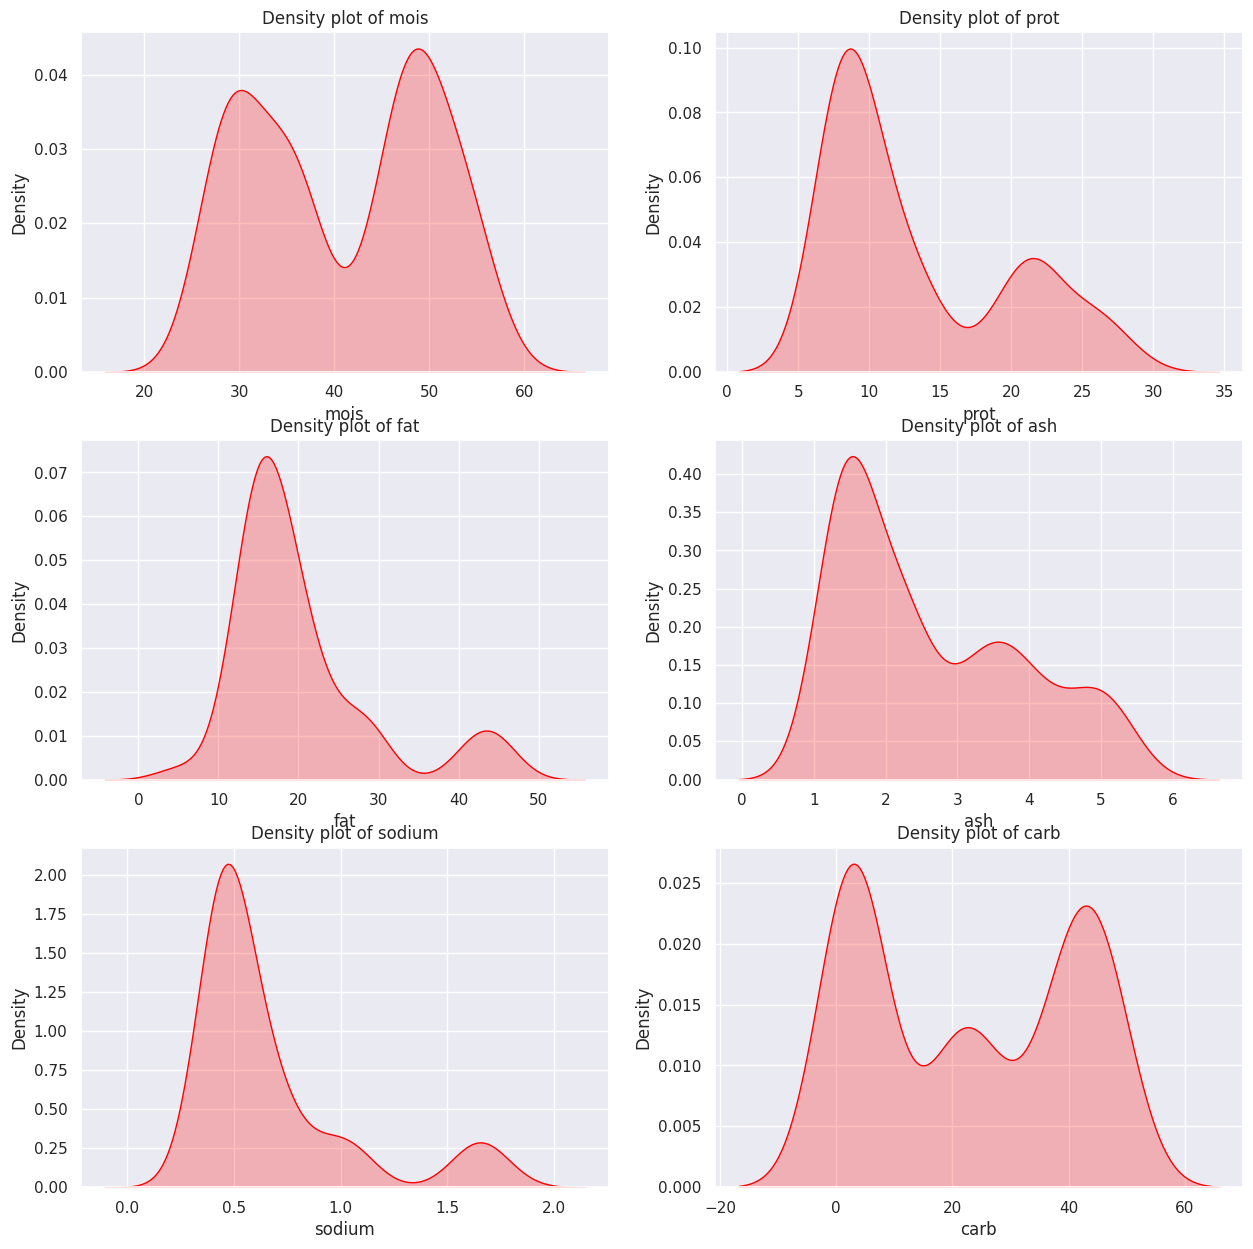

In [16]:
density(data,numerical_columns,(15,15),'red',3,2)

The densities enable us to see the distribution of the data. : 
* Variable `mois` : We can see that generraly 30g and 50g athe the two typical values of the amount of water per 100 grams in the pizza. The question to as is, are there typicall norms of two brands of pizzas.

* Variable `prot` : The density of the amount of proteins per 100 grams in the pizza is centered around 10g. We can notice that there are some pizzas that have a high amount of proteins (An other density peak around 20g).

* Variable `fat` : Most of the pizzas have 12g of fat per 100 grams.

* Variable `ash` : Most of the pizzas have 2g of ash per 100 grams.

* Variable `sodium` : Most of the pizzas have 0.5g of sodium per 100 grams.

* Variable `carb` : The density of this variables show three typical values : 5g, 20g and 50g.



## 🔤Qualitative Variables🔤

Text(0.5, 1.0, 'Count plot of Pizza Brands')

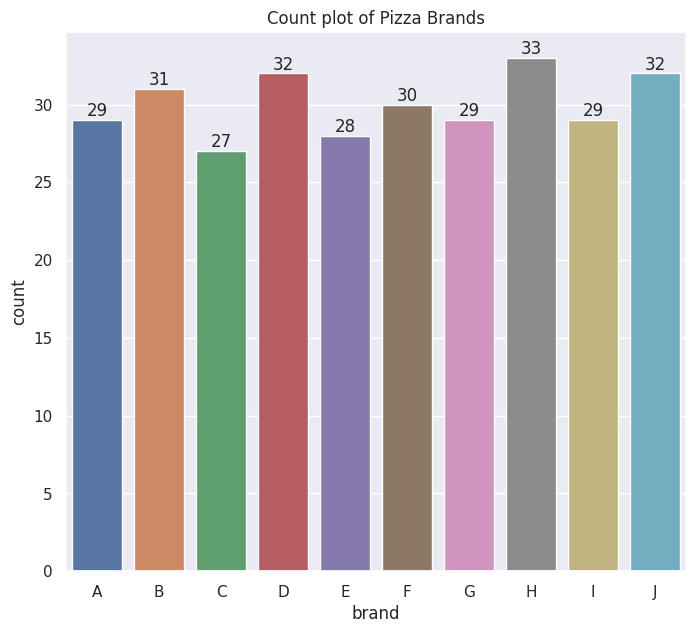

In [17]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
sns.countplot(data=data,x='brand',axes=ax)
ax.bar_label(ax.containers[0],label_type='edge')
ax.set_title("Count plot of Pizza Brands")

We can notice that the counts of the different brand are nearly the same. This is a good thing because it means that the model will not be biased towards a specific brand.

## 🔄📊Bi-Variate Analysis🔄📊

### Correlation Matrix

<Axes: >

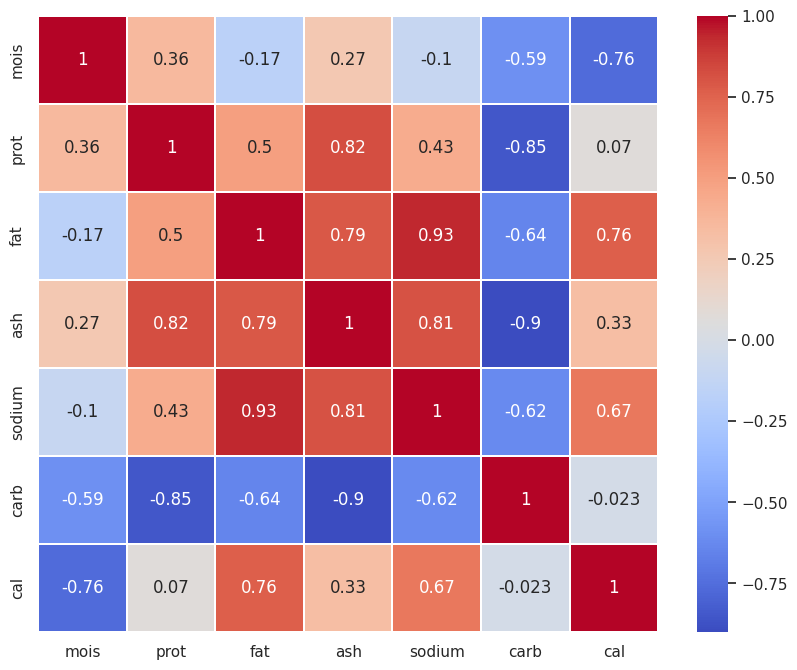

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.2)

We can notice that there are some strong correlations between some variables. For example :

* `cal`  is positively correlaed with `fat` (0.76) which is normal because fat is a source of calories.


To witness the correlation between the variables, we will make a pairplot.

### Pairplot

Text(0.5, 1.02, 'Pairplot of numerical columns colored by brand')

<Figure size 1000x800 with 0 Axes>

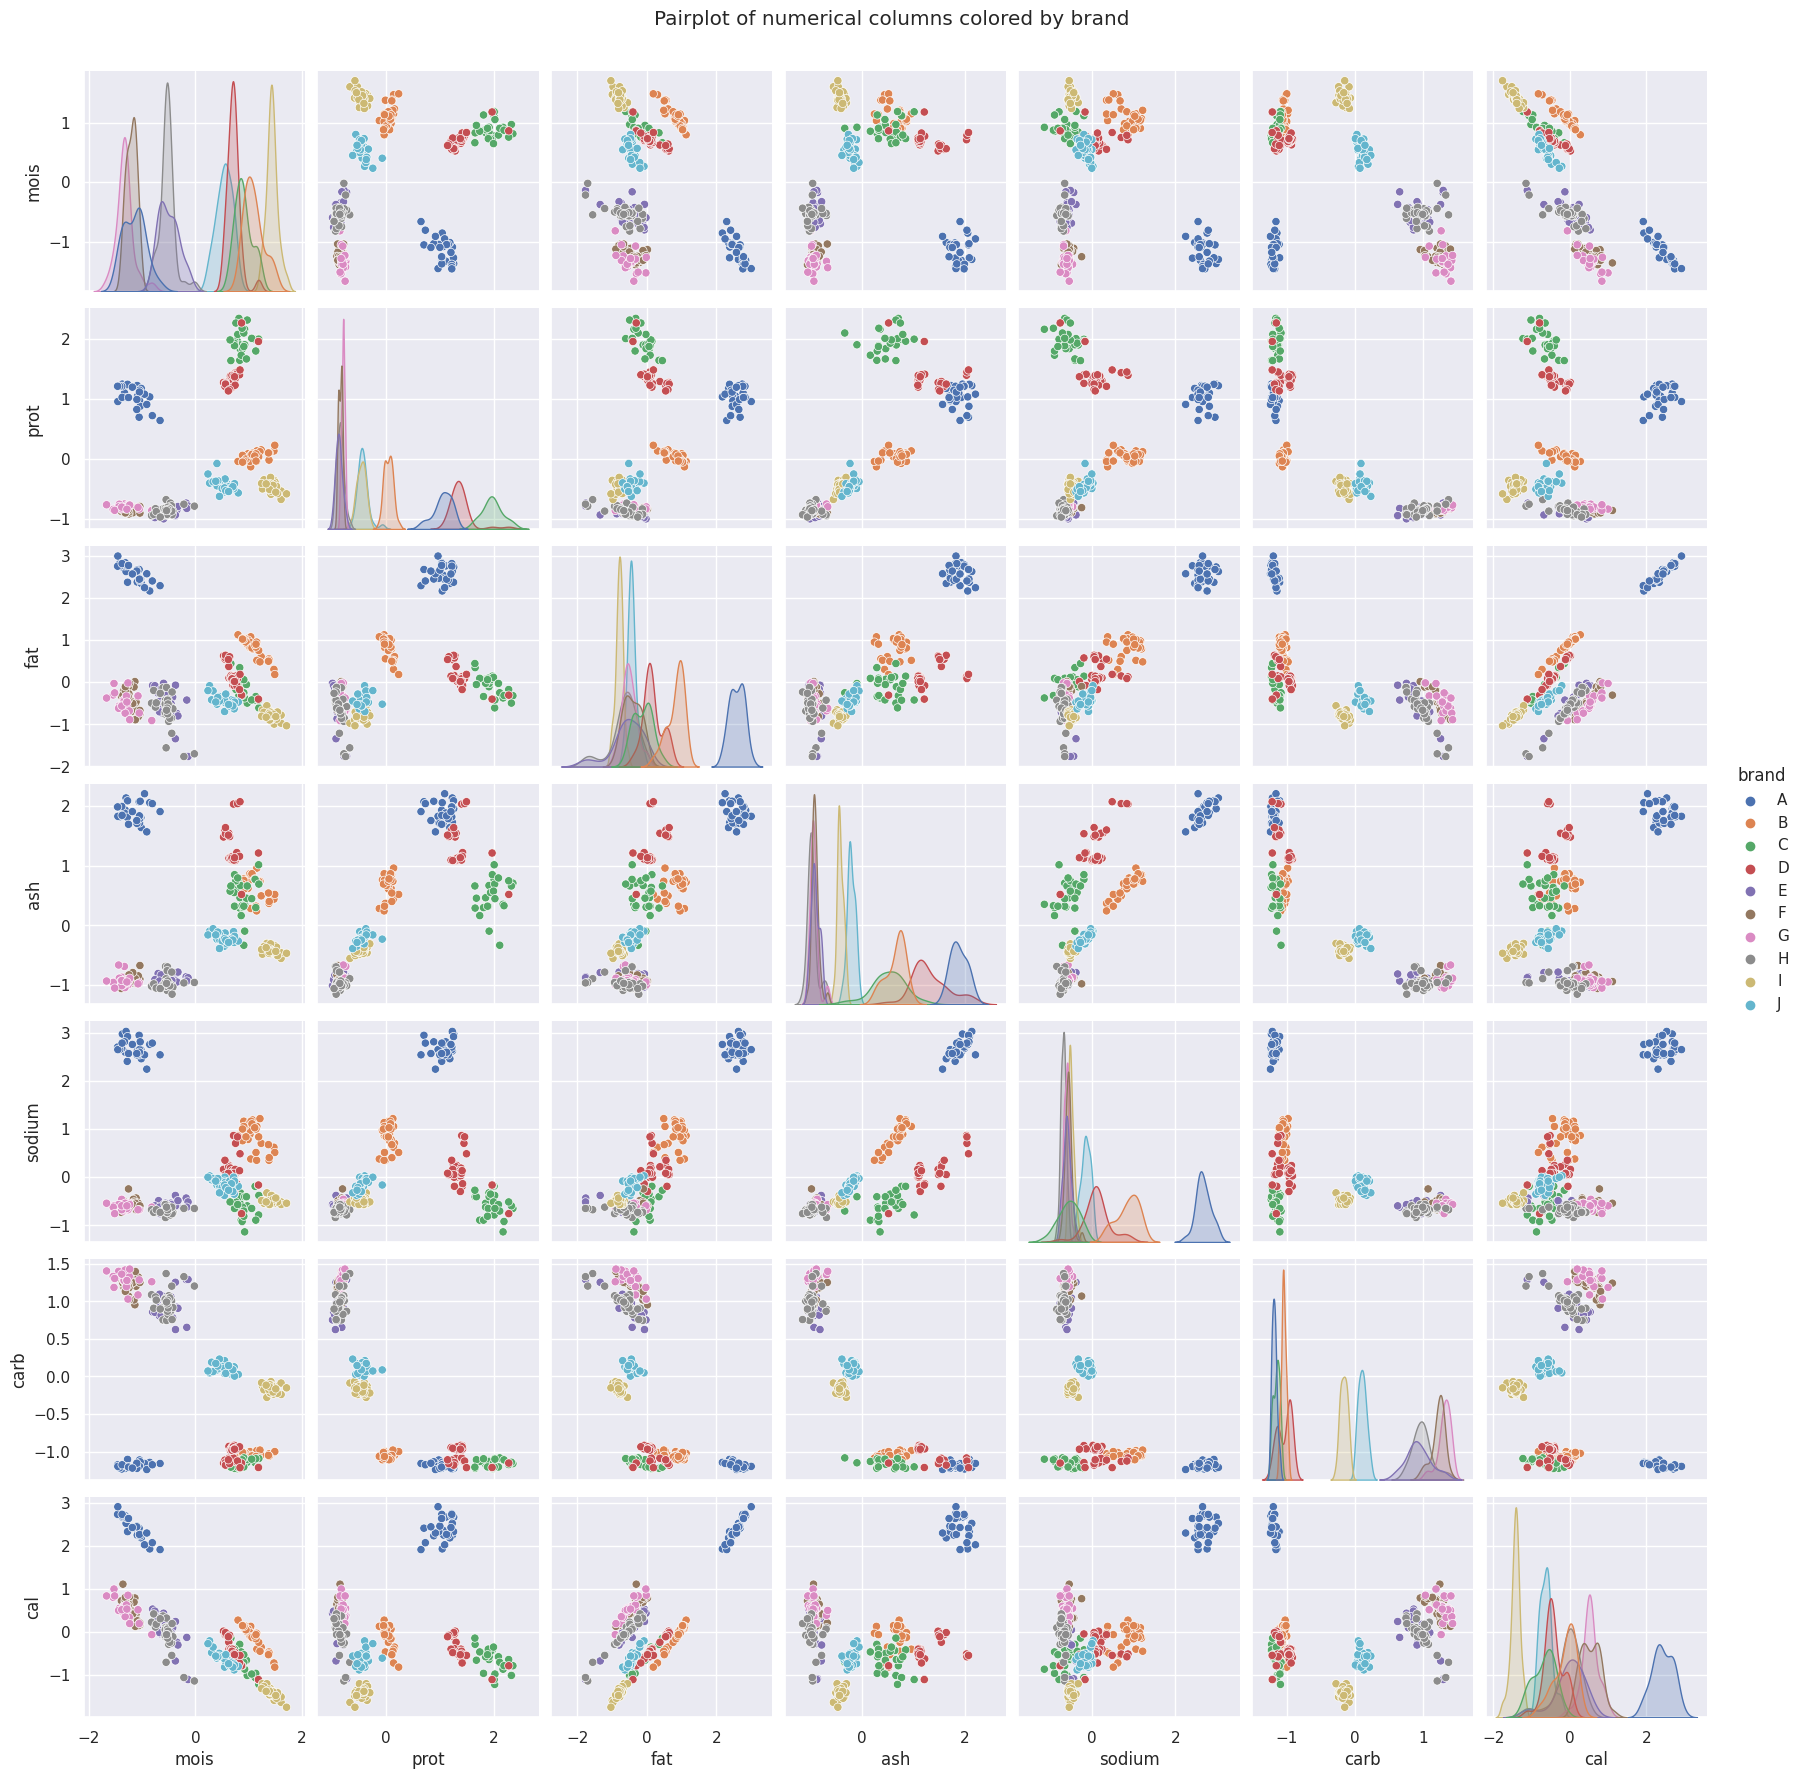

In [19]:
plt.figure(figsize=(10,8))
sns.pairplot(df,vars= numerical_columns,hue='brand')
plt.suptitle("Pairplot of numerical columns colored by brand", y=1.02)

# 📈Méthodes factorielles📈

In this part, I am going to perform Principal Coponent Analysis (PCA) in order to see if we can reduce the dimension of the data and if we can see some differences between the brands of pizzas.

## Principal Component Analysis

In [20]:
from sklearn.decomposition import PCA


In [21]:
pca = PCA()
pca.fit(df[numerical_columns])

PCA()

### Explained Variance

Text(0.5, 1.0, 'Cimulative Explained Variance')

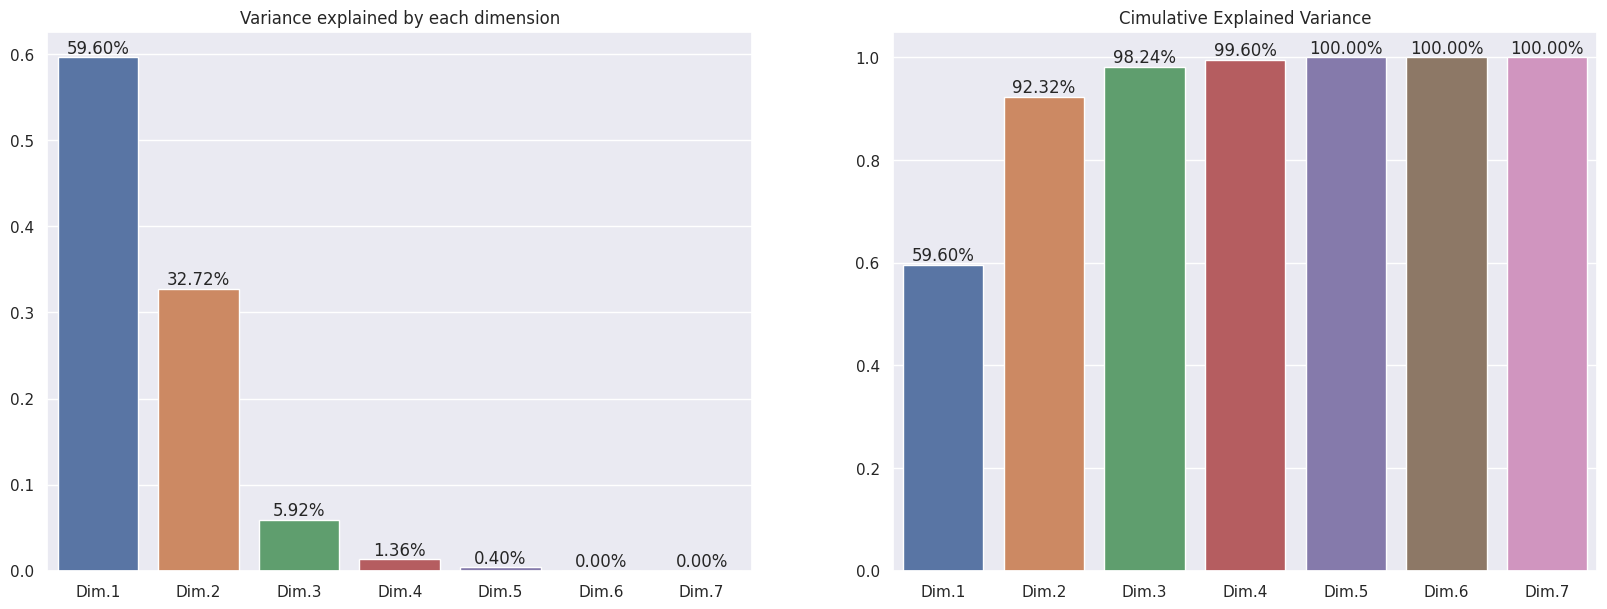

In [22]:
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)




fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=variance,ax=ax[0])
ax[0].bar_label(ax[0].containers[0], labels=[f'{val:.2%}' for val in variance], label_type='edge')
ax[0].set_title("Variance explained by each dimension")


sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=cumulative_variance,ax=ax[1])
ax[1].bar_label(ax[1].containers[0], labels=[f'{val:.2%}' for val in cumulative_variance], label_type='edge')
ax[1].set_title("Cimulative Explained Variance")


We can deduce that 2 PCA components are enough to explain 90% of the variance of the data and therefore 90% of the information.

### Individual Factor Map

In [23]:
def pca_plot_individuals(pca,data=df,pca_variables=numerical_columns,n_pca=df.shape[0],n_plot=df.shape[0],inverse=False,markers=False,edgecolor='black',dim1=1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_pca < n_plot:
        n_plot = n_pca

    if is_categorical:
        is_numerical=False
    else:
        is_numerical=True
    

    subset_df = data.sample(n_pca)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= pca.transform(subset_df[pca_variables])
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, len(pca_variables) + 1)])
    C['brand']=subset_df['brand']

    plt.figure(figsize=size)
    C_sample = C.sample(n_plot)
    names=C_sample.index
    if to_c and c_column : 
        c= subset_df.loc[C_sample.index,c_column]
    
    if is_categorical:
        scatter = sns.scatterplot(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],hue=c,edgecolor=edgecolor)
    elif is_numerical:
        scatter = plt.scatter(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],c=c,edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    if to_c and is_numerical :
        cbar=plt.colorbar(scatter)
        cbar.ax.set_title(c_column)
    plt.title(f"Individual plot of PCA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()
        

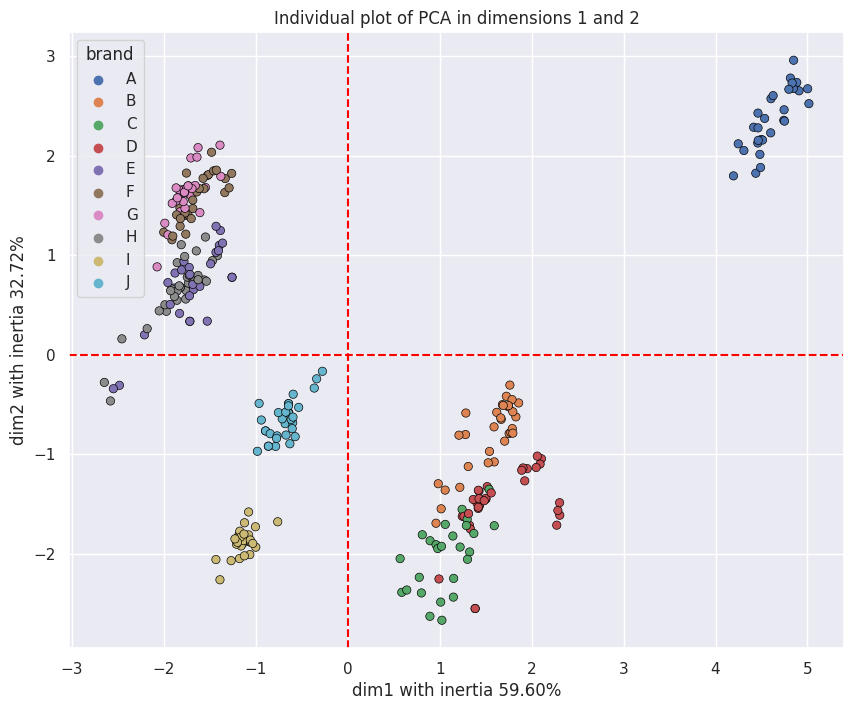

In [24]:
pca_plot_individuals(pca,to_c=True,markers=False,c_column='brand',size=(10,8),is_categorical=True)

We can notice that some brands are generaly pretty well separated. However, others are. For example, we can notice that the brands `C`, `D` and `B` are not well separated. 

Moreover, after checking the variables correlation plot, we can deduce the following information :

* The brand `A` is characterized in one hand by a high amount of `Fat` and `Sodium` and `Protetin` with a low amount of `Carbs` and in the other hand with a hight amount of `Calories` and a low amount of `mois`.
* In the opptosite, `E` , `F` , `G` and `H` are characterized by a low amount of `Fat` and `Sodium` and `Protetin` with a high amount of `Carbs` and in the other hand with a medium amount of `Calories` and a medium amount of `mois`.

### Variable Factor Map

In [25]:
def plot_pca_varcor(pca,inverse=False,data=df[numerical_columns],Legend=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    if inverse:
        inverse= -1
    else:
        inverse = +1
    

    conponents = pd.DataFrame(pca.components_,columns=data.columns,index=range(0,len(pca.components_)))
    conponents = conponents[plot_variables]
    coord1 = inverse*conponents.iloc[dim1-1,:] * np.sqrt(pca.explained_variance_[dim1-1])
    coord2 = inverse*conponents.iloc[dim2-1,:] * np.sqrt(pca.explained_variance_[dim2-1])
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = np.arctan(j/i)
        else:
            angle = 0
        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legend:
        plt.legend(plot_variables,loc='best')
    plt.show()



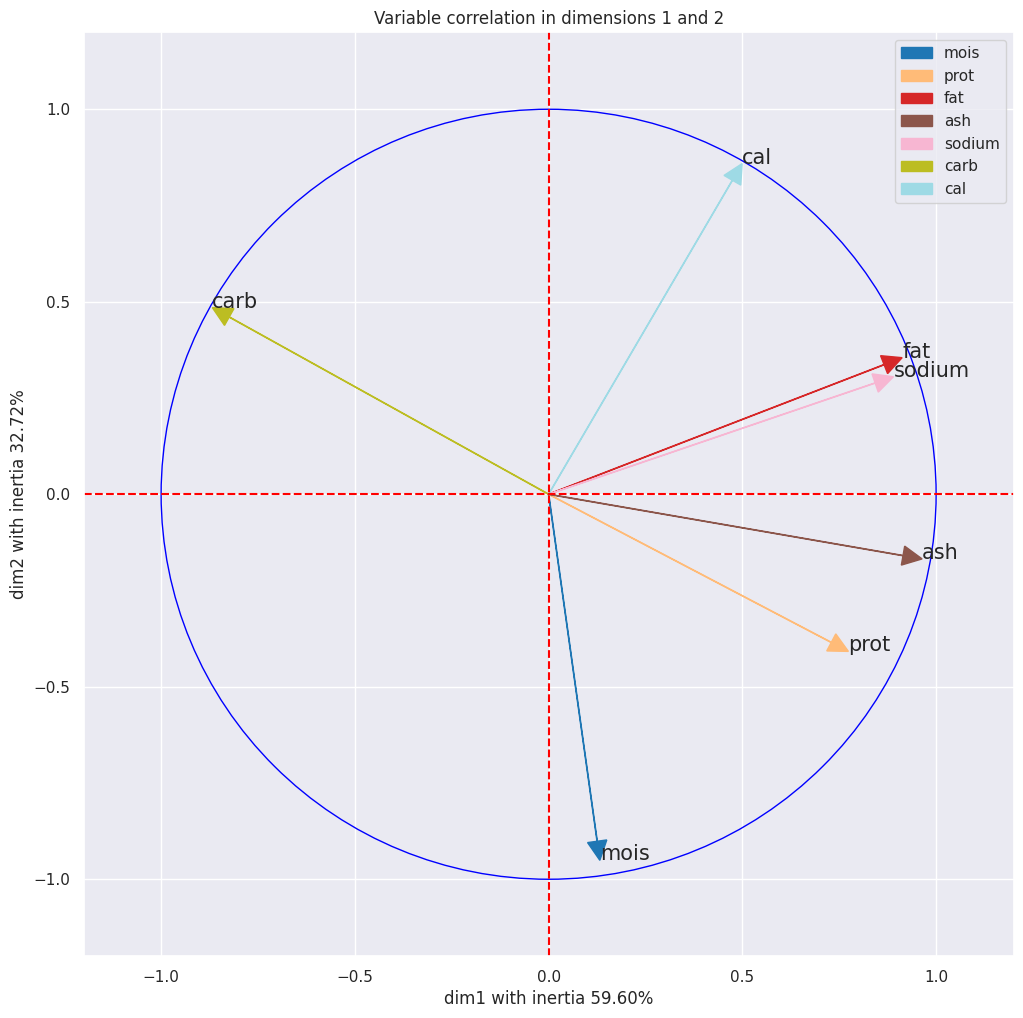

In [23]:
plot_pca_varcor(pca,markers=True,size=(12,12))

We can deduce the following : 

* `Dim1` of our PCA is a positive mean of amounts of `Fat`, `Sodium`, `Proteib` and `Ash` and a negative mean of amounts of `Carbs` 

* `Dim2` is a dimensions which can be considered equal to  `Calories` - `mois`

In orther to see if we can better separate the brands, we will perform a Linear Discriminant Analysis (LDA).

# Linear Discriminant Analysis

In [34]:
df_lda = df.copy()


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

features = df_lda.drop('brand', axis=1)
target = df['brand']
method = LinearDiscriminantAnalysis() 

X_train, X_test ,Y_train,Y_test = train_test_split(features, target, test_size=0.5)
lda = method.fit(X_train, Y_train)
X_r2 = lda.transform(X_train)

In [36]:
lda

LinearDiscriminantAnalysis()

## LDA individual factor map

In [29]:
def lda_plot_individuals(lda,X_train=X_train,Y_train=Y_train,n_lda=X_train.shape[0],n_plot=X_train.shape[0],inverse=False,markers=False,edgecolor='black',dim1 = 1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_lda < n_plot:
        n_plot = n_lda

    if is_categorical:
        is_numerical=False
    else:
        is_numerical=True
    

    subset_df = X_train.sample(n_lda)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= lda.transform(subset_df)
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, X_train.shape[1] + 1)])
    C['brand']=Y_train

    plt.figure(figsize=size)
    C_sample = C.sample(n_plot)
    names=C_sample.index
    if to_c and c_column  and is_numerical: 
        c= subset_df.loc[C_sample.index,c_column]
    elif to_c and c_column and is_categorical:
        c= Y_train

    if is_categorical:
        scatter = sns.scatterplot(x=C_sample['Dim.' + str(dim1)],y=inverse*C_sample['Dim.' + str(dim2)],hue=c,edgecolor=edgecolor)
    elif is_numerical:
        scatter = plt.scatter(x=C_sample['Dim.' + str(dim1)],y=inverse*C_sample['Dim.' + str(dim2)],c=c,edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    if to_c and is_numerical :
        cbar=plt.colorbar(scatter)
        cbar.ax.set_title(c_column)
    plt.title(f"Individual plot of LDA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {lda.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {lda.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()

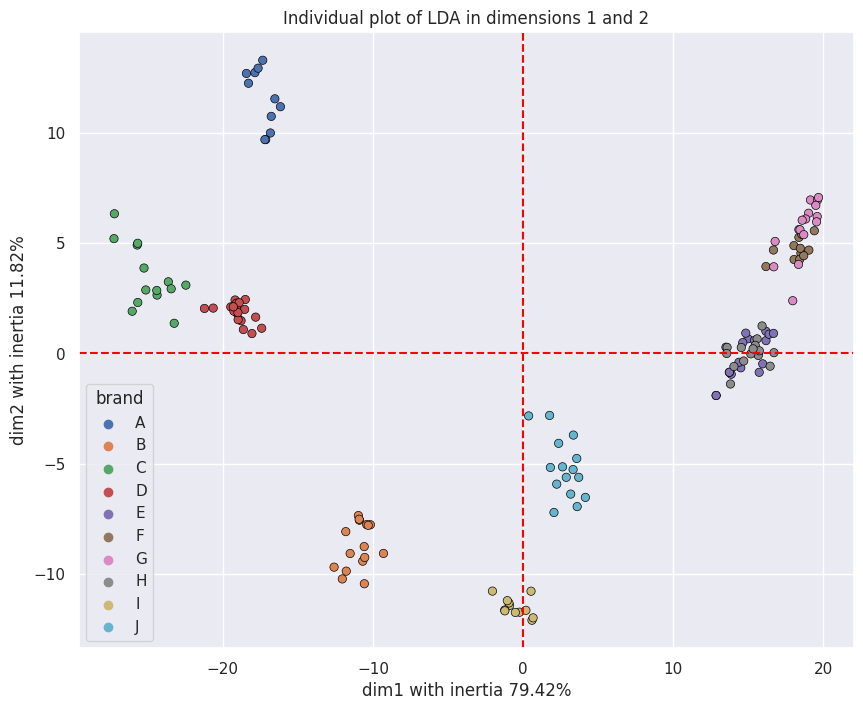

In [30]:
lda_plot_individuals(lda,to_c=True,markers=False,c_column='brand',size=(10,8),is_categorical=True)

We can see that LDA does a better job at separating the brands. However, we can notice that some brands are still not well separated. For example, we can notice that the brands `C`, `D` and `B` are not well separated.

However, we can notice that the different brands points are more compact than in the PCA. This is due to the fact that LDA uses the Within Class Variance as Metric for PCA. Moreover, the fact that we have the same number of observations for each brand helps the model to better separate the brands.

In [27]:
def compute_var_cor(df1,df2):
    correlation_matrix = pd.DataFrame(np.zeros((df1.shape[1], df2.shape[1])),columns=df2.columns,index=df1.columns)


    for i in range(df1.shape[1]):  # Pour chaque colonne de matrix1
        for j in range(df2.shape[1]):  # Pour chaque colonne de matrix2
            correlation_matrix.iloc[i, j] = np.corrcoef(df1.iloc[:, i], df2.iloc[:, j])[0, 1]
    return correlation_matrix

## LDA variable factor map

In [28]:
def lda_plot_varcor(lda,X_train=X_train,Y_train=Y_train,data=df,n_lda = X_train.shape[0] ,lda_variables=numerical_columns,inverse=False,Legned=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    def angle_(i,j) : 
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = -np.arctan(i/j) -np.pi/2
        elif i==0 :
            angle = 0 + (j/abs(j))*np.pi/2
        elif j==0 :
            if i > 0 :
                angle = 0
            else:
                angle = np.pi
        return angle
            
    
    
    
    subset_df = X_train.sample(n_lda)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= lda.transform(subset_df)
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, X_train.shape[1] + 1)])
    initial_data = data.loc[C.index,lda_variables]
    matrix_cor = compute_var_cor(C,initial_data)
    matrix_cor = matrix_cor[plot_variables]

    coord1 = inverse*matrix_cor.iloc[dim1-1,:] 
    coord2 = inverse*matrix_cor.iloc[dim2-1,:]
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        angle = angle_(i,j)

        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Linear Discriminant Analysis : Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legned:
        plt.legend(plot_variables,loc='best')
    plt.show()


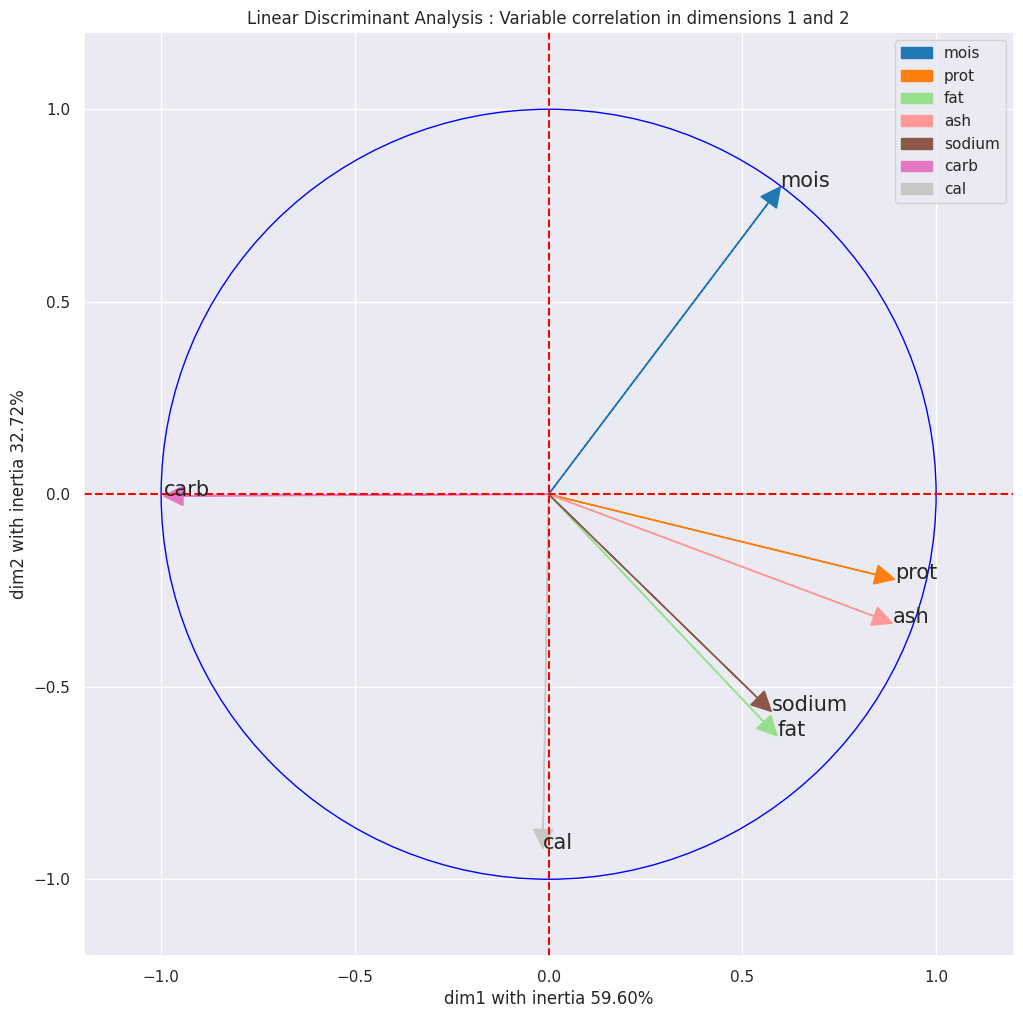

In [29]:
lda_plot_varcor(lda,X_train=X_train,Y_train=Y_train,data=df,lda_variables=numerical_columns,inverse=True,Legned=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12))

The variable factor map of LDA is pretty much the same as the one of PCA.

## Predicting the Brands of a Pizza using LDA

### Splitting the Data

In [30]:
import time

method = LinearDiscriminantAnalysis()
ts = time.time()
method.fit(X_train, Y_train)
scoreLDA = method.score(X_test, Y_test)
ypredLDA = method.predict(X_test)
te = time.time()

### Predicting the Brands

Score : 0.840000, time running : 0 secondes


Text(0.5, 1.0, 'Confusion matrix of LDA')

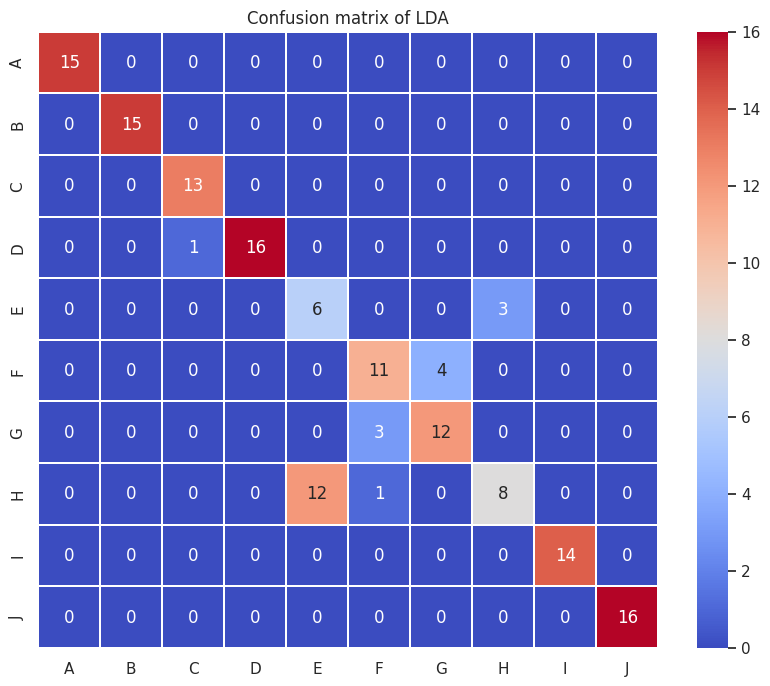

In [31]:
from sklearn.metrics import confusion_matrix
print("Score : %f, time running : %d secondes" %(scoreLDA, te - ts))
labels=np.unique(Y_test)
plt.figure(figsize=(10,8))
confusion_matrix=pd.DataFrame(confusion_matrix(Y_test, ypredLDA),index=labels,columns=labels)
sns.heatmap(confusion_matrix,annot=True,cmap='coolwarm',linewidths=0.1)
plt.title("Confusion matrix of LDA")

We can notice that the model does a pretty good job at predicting the brands of the pizzas. However, we can notice that the model does not predict well the brands `E`, `F`, `G` and `H`. This is due to the fact that these brands are not well separated in the LDA individual factor map.